In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq

In [4]:
llm=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [5]:
print(llm.invoke("What is the capital of France?").content)

<think>
Okay, so I need to figure out the capital of France. Hmm, I'm not entirely sure, but I think it's a city that starts with a 'P'. Let me see... Paris maybe? I've heard of Paris before, it's a famous city with things like the Eiffel Tower and the Louvre Museum. But wait, is that the capital? I'm a bit confused because sometimes cities can be well-known but not necessarily the capital. For example, New York is a big city in the US, but the capital is Washington D.C. So, does France have a similar setup?

I remember learning that some countries have their capital in a city that's not the largest or most famous. But I think in France's case, Paris is both the largest city and the capital. I've also heard of other cities in France like Lyon, Marseille, and Nice, but I don't think any of those are the capital. 

Wait, maybe I should think about government. Where is the French government located? I believe the President of France resides in Paris, so that would make sense as the capita

In [6]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [7]:
search_tool.invoke("What is the capital of France?")

[{'title': 'Paris facts: the capital of France in history',
  'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
  'content': 'page 4\n\n===============\n\nHomeSpainSydneySan FranciscoParisLas VegasMaui\n\n Paris, France\n\nImage 1\n\nParis facts: Paris, the capital of France\n---------------------------------------------\n\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants).\n\nParis has 2.234 million inhabitants end 2011. She is the core of Ile de France region (12 million people). [...] Before Paris, the capital of France was Lyon (under the Romans). Paris first became the capital of France in 508 under King Clovis. After centuries with no unique capital of France, Paris retrieved its status of capital of France under King Philippe Auguste, who reigned between 1180 and 1223. You can see remains of the Philippe August Paris walls in the passageway between the Louvre parking and Louvre Museum [...] Paris remained the capital

In [8]:
my_code = """
x=10
y=x+10
print(y)
"""

In [9]:
from langchain_experimental.utilities import PythonREPL

In [10]:
repl=PythonREPL()

In [11]:
repl.run(my_code)

Python REPL can execute arbitrary code. Use with caution.


'20\n'

In [13]:
from typing import Annotated

In [14]:
from langchain_core.tools import tool

In [15]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [16]:
python_repl_tool.invoke("x=10\ny=x+10\nprint(y)")

'Successfully executed:\n\\`\\`\\`python\nx=10\ny=x+10\nprint(y)\n\\`\\`\\`\nStdout: 20\n'

In [17]:
python_repl_tool.invoke(my_code)

'Successfully executed:\n\\`\\`\\`python\n\nx=10\ny=x+10\nprint(y)\n\n\\`\\`\\`\nStdout: 20\n'

In [18]:
members=["researcher","coder"]

In [19]:
members

['researcher', 'coder']

In [20]:
options = members+["FINISH"]

In [21]:
options

['researcher', 'coder', 'FINISH']

In [22]:
from typing import Literal

In [23]:
from typing_extensions import TypedDict

In [24]:
class Router(TypedDict):
    next: Literal['researcher', 'coder', 'FINISH']

In [25]:
from langgraph.graph import MessagesState,StateGraph,START, END

In [26]:
class State(MessagesState):
    next:str

In [27]:
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [28]:
system_prompt

'"\nYou are a supervisor, tasked with managing a conversation between the following workers: [\'researcher\', \'coder\']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n'

In [29]:
from langgraph.types import Command

In [35]:
def supervisor_agent(state:State)->Command[Literal['researcher', 'coder', '__end__']]:
    
    messages = [{"role": "system", "content": system_prompt},] + state["messages"]
    
    llm_with_structure_output=llm.with_structured_output(Router)
    
    response=llm_with_structure_output.invoke(messages)
    
    #this is my next worker agent
    goto=response["next"]
    
    print("**********BELOW IS MY GOTO***************")
    
    print(goto)
    
    if goto == "FINISH":
        goto=END
        
    return Command(goto=goto, update={"next":goto})
   

In [36]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import AIMessage, HumanMessage

In [37]:
def research_agent(state: State) -> Command[Literal["supervisor"]]:
    
    research_agent = create_react_agent(llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math.")
    
    result=research_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )
    

In [38]:
def coder_agent(state:State)->Command[Literal['supervisor']]:
    code_agent=create_react_agent(llm,tools=[python_repl_tool], prompt="You are a coder. DO NOT do any research.")
    result=code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [39]:
graph=StateGraph(State)
graph.add_node("supervisor", supervisor_agent)
graph.add_node("researcher", researcher_agent)
graph.add_node("coder", coder_agent)
graph.add_edge(START, "supervisor")
app=graph.compile()

In [40]:
from IPython.display import display,Image

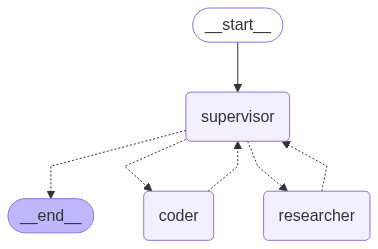

In [41]:
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
(('coder:52d9c350-4592-a941-e266-dd1113e56e89',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v5kzx3s89', 'function': {'arguments': '{"code":"import math\\nsqrt_42 = math.sqrt(42)\\nprint(\\"The square root of 42 is\\", sqrt_42)"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 407, 'prompt_tokens': 189, 'total_tokens': 596, 'completion_time': 6.167494265, 'prompt_time': 0.102786263, 'queue_time': 0.9944192219999999, 'total_time': 6.270280528}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8aeea830-361f-4651-92ef-f4f5e5672910-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nsqrt_42 = math.sqrt(42)\nprint("The square root of 42 is

In [46]:
for s in app.stream({"messages": [("user", "what is square of 53?")]}, subgraphs=True):
    print(s)
    print("**********BELOW IS MY STATE***************")

**********BELOW IS MY GOTO***************
coder
((), {'supervisor': {'next': 'coder'}})
**********BELOW IS MY STATE***************
(('coder:cf0cc0ff-1570-5db5-fec8-44418f743d3b',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gdr0sfc7z', 'function': {'arguments': '{"code":"print(53 * 53)"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 348, 'prompt_tokens': 187, 'total_tokens': 535, 'completion_time': 1.318903615, 'prompt_time': 0.012507675, 'queue_time': 0.05865426500000001, 'total_time': 1.3314112900000001}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--90bc0f5c-2e56-4acb-aac6-0de7102f260d-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'print(53 * 53)'}, 'id': 'gdr0sfc7z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 187, 'output_tokens': 348, 'total_tokens'

In [47]:
app.invoke({"messages": [("user", "Please provide me an effitient python code for prime number?")]}, subgraphs=True)

**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
coder
**********BELOW IS MY GOTO***************
researcher


((),
 {'messages': [HumanMessage(content='Please provide me an effitient python code for prime number?', additional_kwargs={}, response_metadata={}, id='e424e83e-0f16-44a2-9ee1-6fc853d48470'),
   HumanMessage(content="Here's an efficient Python function to check for prime numbers using the 6k ± 1 optimization:\n\n```python\ndef is_prime(n):\n    if n <= 1:\n        return False\n    if n <= 3:\n        return True\n    if n % 2 == 0 or n % 3 == 0:\n        return False\n    i = 5\n    w = 2\n    while i * i <= n:\n        if n % i == 0:\n            return False\n        i += w\n        w = 6 - w\n    return True\n\n# Example usage\nprint(is_prime(101))  # Should return True\n```\n\nThis function efficiently checks for primality by:\n1. Handling small numbers directly\n2. Eliminating even numbers and multiples of 3 early\n3. Checking divisibility using the 6k ± 1 optimization\n4. Only checking up to the square root of n", additional_kwargs={}, response_metadata={}, name='coder', id='ea